# DM-33104 : resize masks

Is it even possible to make a mask have a different size or be evaluated at a different location inside the postage stamp?

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
)
import os

from lsst.daf import butler as dafButler
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

In [2]:
def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog


def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId, 
                          collections=[collection])
    return postIsr



In [3]:
def plot_comp_img(imgIntra,imgExtra,i, title='before'):
    for img, label in zip([imgIntra,imgExtra],
                          ['intra','extra']):
        fig,axs = plt.subplots(2,3,figsize=(12,8))
        ax = np.ravel(axs)
        mask_pupil = img.getNonPaddedMask()
        mask_comp = img.getPaddedMask()
        image = img.getImg()
        ax[0].imshow(mask_pupil, origin='lower')
        ax[0].set_title('mask_pupil')
        ax[1].imshow(mask_comp,origin='lower')
        ax[1].set_title('mask_comp')
        ax[2].imshow(image,origin='lower')
        ax[2].set_title('img')
        ax[3].imshow(image/mask_pupil,origin='lower')
        ax[4].imshow(image/mask_comp,origin='lower')
        ax[5].axis('off')
        fig.suptitle(sensor+f' donut {i}'+f' {label} {title} fitting', fontsize=17)

In [4]:
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import DefocalType, CamType, CentroidFindType
from scipy.ndimage import rotate

In [5]:
# Load the stamps
repo_dir  = '/project/scichris/aos/masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

# iterate over all sensors
#for sensor in ['R00','R40','R44','R04']: 
    
# schoose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()


configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# inside   wfEsti = WfEstimator(instDir, algoDir)

# this is part of the init 
inst = Instrument(instDir)
algo = Algorithm(algoDir)

# inside estimateZernikes()
# instName gets specified in the config,
# and does not get overridden for CWFS
instName='lsst'  
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# inside  wfEsti.config update the parameters 
opticalModel = 'offAxis'
sizeInPix = 160 # int(sizeInPix)
inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm 
solver = 'exp' # by default 
debugLevel=0 # 1 to 3 
algo.config(solver, inst, debugLevel=debugLevel)



centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

###
# now we'd normally loop over donut images 
###

#for now , just choose the first pair... 
i=0
#for donutExtra, donutIntra in zip(donutStampsExtra, donutStampsIntra):
donutExtra = donutStampsExtra[i]
donutIntra = donutStampsIntra[i]

fieldXYExtra = donutExtra.calcFieldXY()
fieldXYIntra = donutIntra.calcFieldXY()

camera = donutExtra.getCamera()
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)


# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

# inside  `wfEsti.setImg` 
# right after we set the image, the compensable image mask is empty
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


That's the call to `makeMask`:

In [8]:
# calcualate the mask to plot it before fitting ... 
# it is only calculated in algo
# https://github.com/lsst-ts/ts_wep/blob/d41a81fe380c09432950d0db933e7b664b8782ea/python/lsst/ts/wep/cwfs/Algorithm.py#L694
maskScalingFactorLocal = 1
boundaryT = algo.getBoundaryThickness()
imgIntra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)
imgExtra.makeMask(inst, opticalModel, boundaryT, maskScalingFactorLocal)


Below we dissect this function. 

Parts of `CompensableImage` `makeMask` routine (self, inst, model, boundaryT, maskScalingFactorLocal):

In [110]:
dimOfDonut = inst.getDimOfDonutOnSensor()
print('dimOfDonut', dimOfDonut)
imgExtra.mask_pupil = np.ones(dimOfDonut, dtype=int)
imgExtra.mask_comp = mask_pupil.copy()

apertureDiameter = inst.getApertureDiameter()
focalLength = inst.getFocalLength()
offset = inst.getDefocalDisOffset()
rMask = apertureDiameter / (2 * focalLength / offset) * maskScalingFactorLocal

# Get the mask list
pixelSize = inst.getCamPixelSize()
xSensor, ySensor = inst.getSensorCoor()


print('apertureDiameter', apertureDiameter)
print('focalLength ' ,focalLength)
print('offset',offset)
print('rMask', rMask)
print('pixelSize', pixelSize)


dimOfDonut 160
apertureDiameter 8.36
focalLength  10.312
offset 0.0015
rMask 0.0006080294802172227
pixelSize 1e-05


In [96]:
model = opticalModel
imgExtra.makeMaskList(inst,model)

array([[0.        , 0.        , 1.        , 1.        ],
       [0.        , 0.        , 0.61      , 0.        ],
       [0.22338478, 0.19299901, 1.22297988, 1.        ],
       [0.08913064, 0.0770067 , 0.56446576, 0.        ]])

what does `makeMaskList` do ? 

In [11]:
inst.getMaskOffAxisCorr()

array([[ 1.07      , -0.1774854 ,  1.1354704 , -0.07904368,  0.58907132],
       [ 1.09875   , -0.2214493 ,  1.1723643 , -0.11442883,  0.56075617],
       [ 1.1275    , -0.23577584,  1.1796208 , -0.09010086,  0.58508414],
       [ 1.15625   , -0.28427971,  1.2210547 , -0.12422927,  0.55802573],
       [ 1.185     , -0.30038724,  1.2300922 , -0.12422927,  0.55802573],
       [ 1.21375   , -0.28148162,  1.2041166 , -0.10070898,  0.58154602],
       [ 1.2425    , -0.6253234 ,  1.5055384 , -0.13367676,  0.55564824],
       [ 1.27125   , -2.9963363 ,  3.7563613 , -0.1109071 ,  0.5784179 ],
       [ 1.3       , -3.026284  ,  3.666119  , -0.17174724,  0.53171776]])

In [112]:
model=opticalModel

# Masklist = [center_x, center_y, radius_of_boundary,
#             1/ 0 for outer/ inner boundary]
obscuration = inst.getObscuration()
if model in ("paraxial", "onAxis"):

    if obscuration == 0:
        masklist = np.array([[0, 0, 1, 1]])
    else:
        masklist = np.array([[0, 0, 1, 1], [0, 0, obscuration, 0]])
else:
    # Get the mask-related parameters
    maskCa, maskRa, maskCb, maskRb = imgExtra._interpMaskParam(
        imgExtra.fieldX, imgExtra.fieldY, inst.getMaskOffAxisCorr()
    )

    # Rotate the mask-related parameters of center
    cax, cay, cbx, cby = imgExtra._rotateMaskParam(
        maskCa, maskCb, imgExtra.fieldX, imgExtra.fieldY
    )
    masklist = np.array(
        [
            [0, 0, 1, 1],
            [0, 0, obscuration, 0],
            [cax, cay, maskRa, 1],
            [cbx, cby, maskRb, 0],
        ]
    )

In [113]:
# Inside _intrepMaskParam 
fieldX = imgExtra.fieldX
fieldY = imgExtra.fieldY
# Calculate the distance from donut to origin (aperture)
fieldDist = np.sqrt(fieldX**2 + fieldY**2)

# Get the ruler, which is the distance to center
# ruler is between 1.51 and 1.84 degree here
ruler = np.sqrt(2) * maskParam[:, 0]

# Get the fitted parameters for off-axis correction by linear
# approximation
#param = self._linearApprox(fieldDist, ruler, maskParam[:, 1:])

# Define related parameters
# ca = param[0]
# ra = param[1]
# cb = param[2]
# rb = param[3]
print(fieldDist)

1.6869757166814343


This is the grid of distances over which the model coefficients got evaluated in Zemax

In [36]:
print(ruler)

[1.51320851 1.55386715 1.59452579 1.63518443 1.67584307 1.71650171
 1.75716035 1.79781899 1.83847763]


In [114]:
# inside _linearApprox
parameters = maskParam[:, 1:]
# Sort the ruler and parameters based on the magnitude of ruler
sortIndex = np.argsort(ruler)
ruler = ruler[sortIndex]
parameters = parameters[sortIndex, :]

# Compare the distance to center (aperture) between donut and standard
compDis = ruler >= fieldDist

# fieldDist is too big and out of range
if fieldDist > ruler.max():
    # Take the coefficients in the highest boundary
    p2 = parameters.shape[0] - 1
    p1 = 0
    w1 = 0
    w2 = 1

# fieldDist is too small to be in the range
elif fieldDist < ruler.min():
    # Take the coefficients in the lowest boundary
    p2 = 0
    p1 = 0
    w1 = 1
    w2 = 0

# fieldDist is in the range
else:
    # Find the boundary of fieldDist in the known data
    p2 = compDis.argmax()
    p1 = p2 - 1

    # Calculate the weighting ratio
    w1 = (ruler[p2] - fieldDist) / (ruler[p2] - ruler[p1])
    w2 = 1 - w1

# Get the fitted parameters for off-axis correction by linear
# approximation
param = w1 * parameters[p1, :] + w2 * parameters[p2, :]

In [43]:
fieldDist

1.6869757166814343

In [44]:
ruler

array([1.51320851, 1.55386715, 1.59452579, 1.63518443, 1.67584307,
       1.71650171, 1.75716035, 1.79781899, 1.83847763])

Text(0.5, 0, 'index')

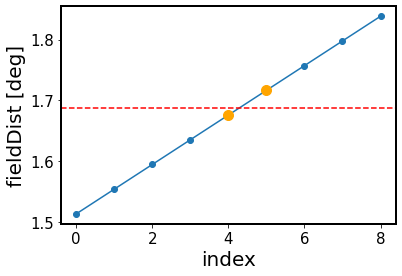

In [71]:


plt.plot(ruler, ls='-', marker='o')
plt.axhline(fieldDist, c='red', ls='--')
plt.scatter(p1, ruler[p1], c='orange',s=100, zorder=100)
plt.scatter(p2, ruler[p2], c='orange',s=100, zorder=100)
plt.ylabel('fieldDist [deg]')
plt.xlabel('index')
#plt.scatt

Then these are rotated:

In [115]:
maskCa, maskRa, maskCb, maskRb = param
cax, cay, cbx, cby = imgExtra._rotateMaskParam(
        maskCa, maskCb, imgExtra.fieldX, imgExtra.fieldY
    )
masklist = np.array(
    [
        [0, 0, 1, 1],
        [0, 0, obscuration, 0],
        [cax, cay, maskRa, 1],
        [cbx, cby, maskRb, 0],
    ]
)

Then we go over the masklist. It contains:

    [center_x, center_y, radius_of_boundary,  1/ 0 for outer/ inner boundary]

In [80]:
masklist[]

array([[0.        , 0.        , 1.        , 1.        ],
       [0.        , 0.        , 0.61      , 0.        ],
       [0.22338478, 0.19299901, 1.22297988, 1.        ],
       [0.08913064, 0.0770067 , 0.56446576, 0.        ]])

In [86]:
range(masklist.shape[0])

range(0, 4)

In [89]:
nrows = masklist.shape[0]

0.0
0.0
0.22338478419141075
0.08913064338035204


Text(0.5, 1.0, 'mask_comp')

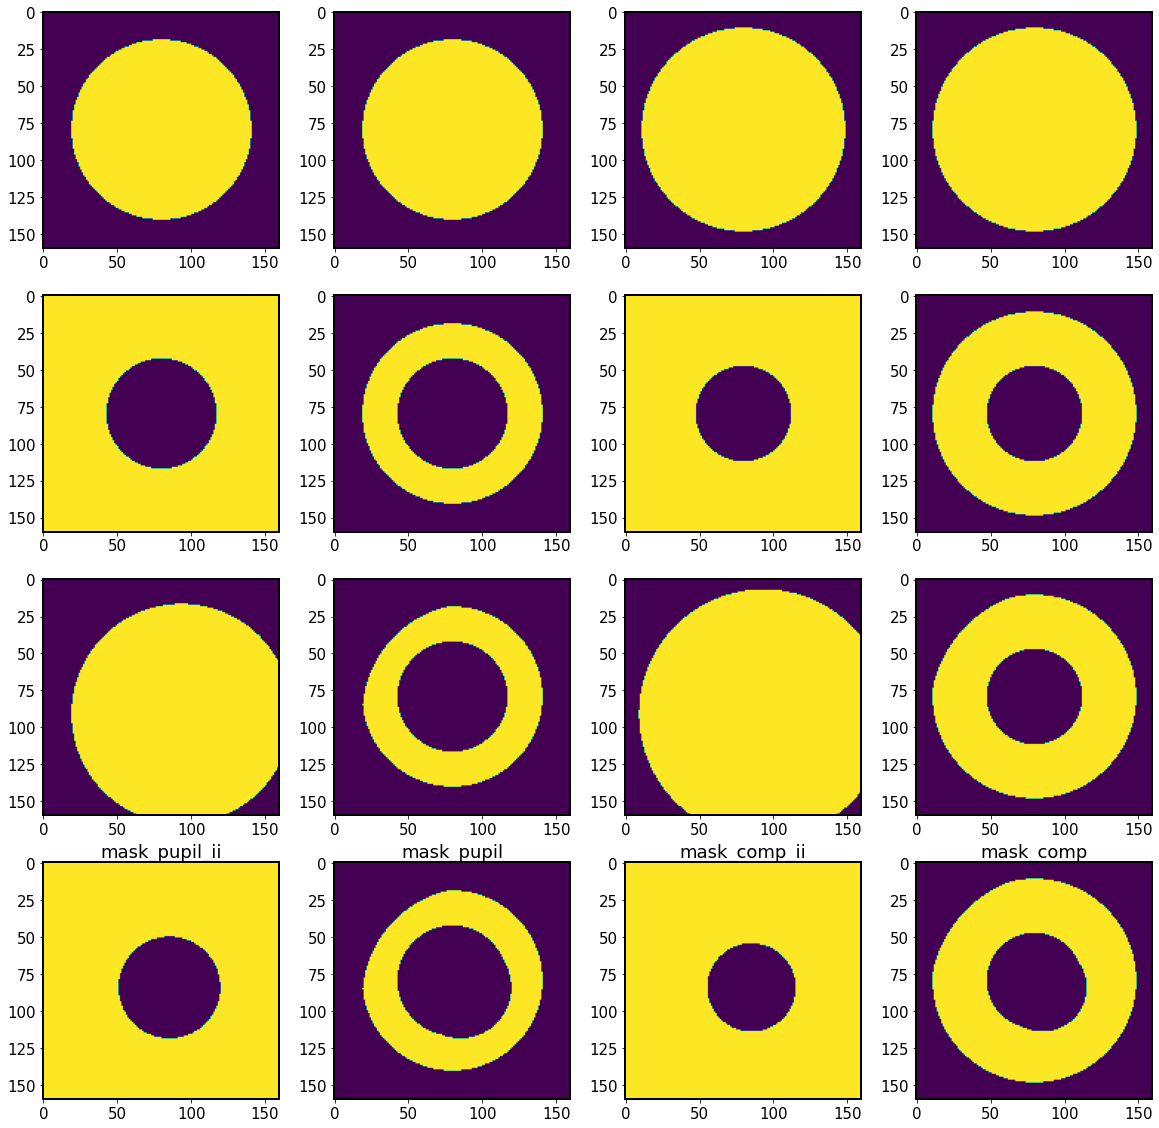

In [116]:
fig, ax = plt.subplots(nrows,4, figsize=(20,nrows*5))

for ii in range(masklist.shape[0]):
    print(masklist[ii,0])
    # Distance to center on pupil
    r = np.sqrt(
        (xSensor - masklist[ii, 0]) ** 2 + (ySensor - masklist[ii, 1]) ** 2
    )

    # Find the indices that correspond to the mask element, set them to
    # the pass/ block boolean

    # Get the index inside the aperture
    idx = r <= masklist[ii, 2]

    # Get the higher and lower boundary beyond the pupil mask by
    # extension.
    # The extension level is dicided by boundaryT.
    # In fft, this is also the Neuman boundary where the derivative of
    # the wavefront is set to zero.
    if masklist[ii, 3] >= 1:
        aidx = np.nonzero(
            r <= masklist[ii, 2] * (1 + boundaryT * pixelSize / rMask)
        )
    else:
        aidx = np.nonzero(
            r <= masklist[ii, 2] * (1 - boundaryT * pixelSize / rMask)
        )

    # Initialize both mask elements to the opposite of the pass/ block
    # boolean
    mask_pupil_ii = (1 - int(masklist[ii, 3])) * np.ones(
        [dimOfDonut, dimOfDonut], dtype=int
    )
    mask_comp_ii = mask_pupil_ii.copy()

    mask_pupil_ii[idx] = int(masklist[ii, 3])
    mask_comp_ii[aidx] = int(masklist[ii, 3])

    ax[ii,0].imshow(mask_pupil_ii)
    ax[ii,2].imshow(mask_comp_ii)
    
    # Multiplicatively add the current mask elements to the model
    # masks.
    # This is try to find the common mask region.

    # non-padded mask corresponding to aperture
    imgExtra.mask_pupil = imgExtra.mask_pupil * mask_pupil_ii
    ax[ii,1].imshow(imgExtra.mask_pupil)
    
    # padded mask for use at the offset planes
    imgExtra.mask_comp = imgExtra.mask_comp * mask_comp_ii
    ax[ii,3].imshow(imgExtra.mask_comp)
    
ax[ii,0].set_title('mask_pupil_ii')
ax[ii,1].set_title('mask_pupil')

ax[ii,2].set_title('mask_comp_ii')
ax[ii,3].set_title('mask_comp')

Put the above in a function:

In [26]:
def show_make_mask(imgExtra,inst ,algo, maskScalingFactorLocal = 1,
             maskCaRaCbRb = []):
    
    boundaryT = algo.getBoundaryThickness()
    
    dimOfDonut = inst.getDimOfDonutOnSensor()
    print('dimOfDonut', dimOfDonut)
    imgExtra.mask_pupil = np.ones(dimOfDonut, dtype=int)
    imgExtra.mask_comp = imgExtra.mask_pupil.copy()

    apertureDiameter = inst.getApertureDiameter()
    focalLength = inst.getFocalLength()
    offset = inst.getDefocalDisOffset()
    rMask = apertureDiameter / (2 * focalLength / offset) * maskScalingFactorLocal

    # Get the mask list
    pixelSize = inst.getCamPixelSize()
    xSensor, ySensor = inst.getSensorCoor()


    print('apertureDiameter', apertureDiameter)
    print('focalLength ' ,focalLength)
    print('offset',offset)
    print('rMask', rMask)
    print('pixelSize', pixelSize)

    # model = opticalModel
    # inside 
    # imgExtra.makeMaskList(inst,model)

    model=opticalModel

    # Masklist = [center_x, center_y, radius_of_boundary,
    #             1/ 0 for outer/ inner boundary]
    obscuration = inst.getObscuration()
    if model in ("paraxial", "onAxis"):

        if obscuration == 0:
            masklist = np.array([[0, 0, 1, 1]])
        else:
            masklist = np.array([[0, 0, 1, 1], [0, 0, obscuration, 0]])
    else:
        # Get the mask-related parameters
        if len(maskCaRaCbRb)<4:
            print('Using built-in mask params')
            maskCa, maskRa, maskCb, maskRb = imgExtra._interpMaskParam(
            imgExtra.fieldX, imgExtra.fieldY, inst.getMaskOffAxisCorr())
        else:
            print('Using provided mask params ')
            maskCa, maskRa, maskCb, maskRb = maskCaRaCbRb
        print('maskCa, maskRa, maskCb, maskRb: ',maskCa, maskRa, maskCb, maskRb)

        # Rotate the mask-related parameters of center
        cax, cay, cbx, cby = imgExtra._rotateMaskParam(
            maskCa, maskCb, imgExtra.fieldX, imgExtra.fieldY
        )
        masklist = np.array(
            [
                [0, 0, 1, 1],
                [0, 0, obscuration, 0],
                [cax, cay, maskRa, 1],
                [cbx, cby, maskRb, 0],
            ]
        )
    print(masklist)
    
    # inside  makeMask : add plotting at each stage
    nrows = masklist.shape[0] 
    fig, ax = plt.subplots(nrows,4, figsize=(20,nrows*5))

    for ii in range(masklist.shape[0]):
        print(f'\nxSensor- masklist[{ii},0]', masklist[ii,0])
        print(f'ySensor- masklist[{ii},1]', masklist[ii,1])
        
        # Distance to center on pupil
        r = np.sqrt(
            (xSensor - masklist[ii, 0]) ** 2 + (ySensor - masklist[ii, 1]) ** 2
        )

        # Find the indices that correspond to the mask element, set them to
        # the pass/ block boolean

        # Get the index inside the aperture
        idx = r <= masklist[ii, 2]
        print(f'idx = r <= masklist[{ii}, 2]',masklist[ii, 2])
        
        # Get the higher and lower boundary beyond the pupil mask by
        # extension.
        # The extension level is decided by boundaryT.
        # In fft, this is also the Neuman boundary where the derivative of
        # the wavefront is set to zero.
        print(f'if masklist[{ii}, 3] >= 1',masklist[ii, 3])
        if masklist[ii, 3] >= 1:
            aidx = np.nonzero(
                r <= masklist[ii, 2] * (1 + boundaryT * pixelSize / rMask)
            )
        else:
            aidx = np.nonzero(
                r <= masklist[ii, 2] * (1 - boundaryT * pixelSize / rMask)
            )

        # Initialize both mask elements to the opposite of the pass/ block
        # boolean
        mask_pupil_ii = (1 - int(masklist[ii, 3])) * np.ones(
            [dimOfDonut, dimOfDonut], dtype=int
        )
        mask_comp_ii = mask_pupil_ii.copy()

        mask_pupil_ii[idx] = int(masklist[ii, 3])
        mask_comp_ii[aidx] = int(masklist[ii, 3])

        ax[ii,0].imshow(mask_pupil_ii)
        ax[ii,2].imshow(mask_comp_ii)

        # Multiplicatively add the current mask elements to the model
        # masks.
        # This is try to find the common mask region.

        # non-padded mask corresponding to aperture
        imgExtra.mask_pupil = imgExtra.mask_pupil * mask_pupil_ii
        ax[ii,1].imshow(imgExtra.mask_pupil)

        # padded mask for use at the offset planes
        imgExtra.mask_comp = imgExtra.mask_comp * mask_comp_ii
        ax[ii,3].imshow(imgExtra.mask_comp)

    ax[0,0].set_title('mask_pupil_ii')
    ax[0,1].set_title('mask_pupil')

    ax[0,2].set_title('mask_comp_ii')
    ax[0,3].set_title('mask_comp')

To make the mask slightly larger, edit the model parameters: 

dimOfDonut 160
apertureDiameter 8.36
focalLength  10.312
offset 0.0015
rMask 0.0006080294802172227
pixelSize 1e-05
Using built-in mask params
maskCa, maskRa, maskCb, maskRb:  -0.29521073725716857 1.2229798828875915 -0.11778923546544409 0.5644657645345559
[[0.         0.         1.         1.        ]
 [0.         0.         0.61       0.        ]
 [0.22338478 0.19299901 1.22297988 1.        ]
 [0.08913064 0.0770067  0.56446576 0.        ]]

xSensor- masklist[0,0] 0.0
ySensor- masklist[0,1] 0.0
idx = r <= masklist[0, 2] 1.0
if masklist[0, 3] >= 1 1.0

xSensor- masklist[1,0] 0.0
ySensor- masklist[1,1] 0.0
idx = r <= masklist[1, 2] 0.61
if masklist[1, 3] >= 1 0.0

xSensor- masklist[2,0] 0.22338478419141075
ySensor- masklist[2,1] 0.19299900928159672
idx = r <= masklist[2, 2] 1.2229798828875915
if masklist[2, 3] >= 1 1.0

xSensor- masklist[3,0] 0.08913064338035204
ySensor- masklist[3,1] 0.07700670361818081
idx = r <= masklist[3, 2] 0.5644657645345559
if masklist[3, 3] >= 1 0.0


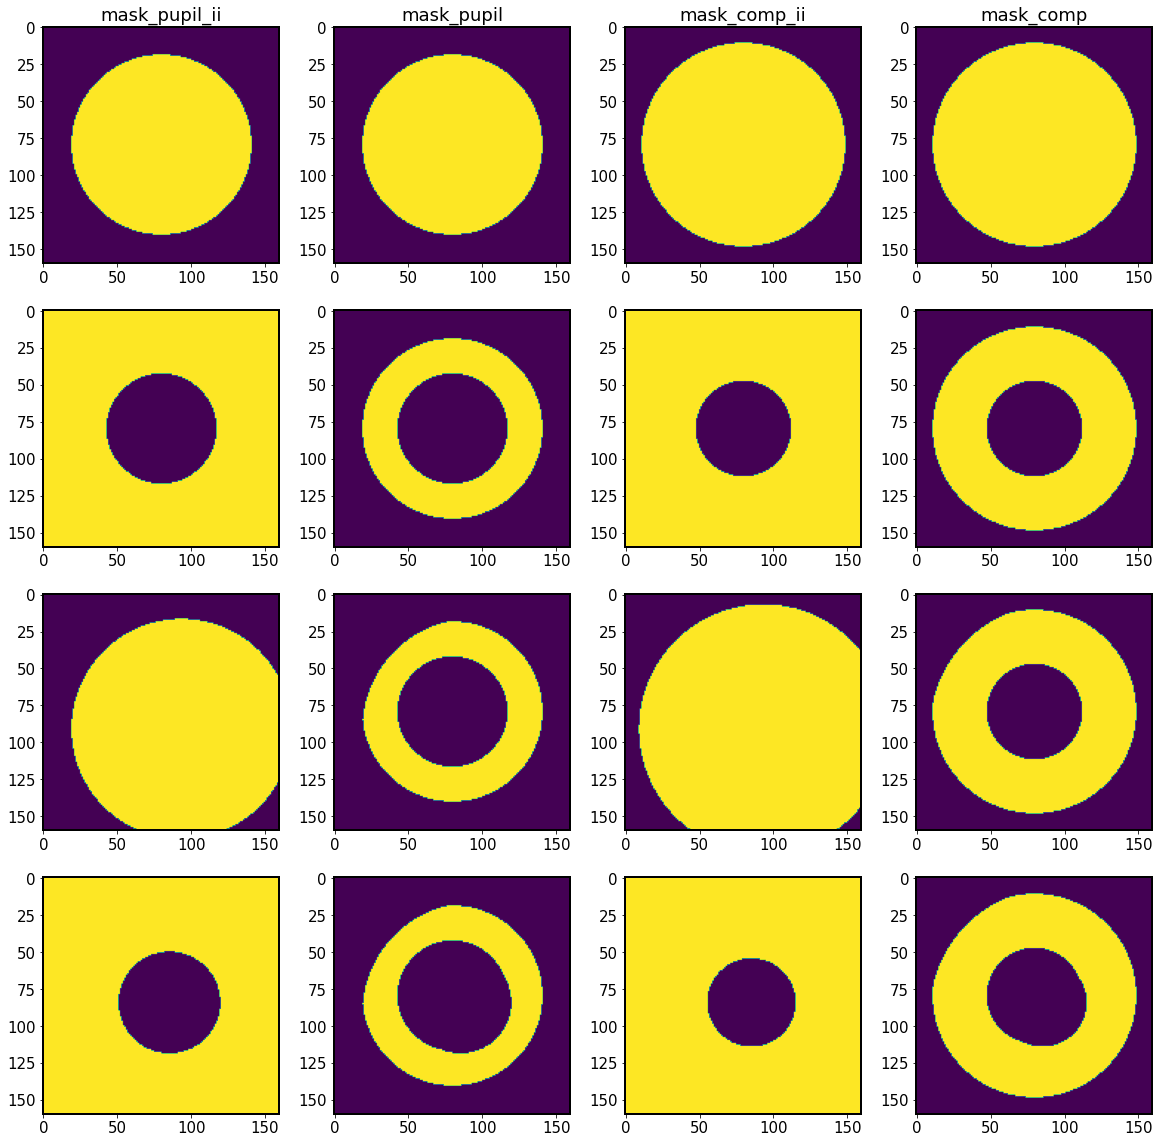

In [25]:
show_make_mask(imgExtra,inst,algo , )

dimOfDonut 160
apertureDiameter 8.36
focalLength  10.312
offset 0.0015
rMask 0.0006080294802172227
pixelSize 1e-05
Using provided mask params 
maskCa, maskRa, maskCb, maskRb:  -0.4552107372571686 1.1229798828875914 -0.11778923546544409 0.5644657645345559
[[0.         0.         1.         1.        ]
 [0.         0.         0.61       0.        ]
 [0.34445614 0.29760171 1.12297988 1.        ]
 [0.08913064 0.0770067  0.56446576 0.        ]]

xSensor- masklist[0,0] 0.0
ySensor- masklist[0,1] 0.0
idx = r <= masklist[0, 2] 1.0
if masklist[0, 3] >= 1 1.0

xSensor- masklist[1,0] 0.0
ySensor- masklist[1,1] 0.0
idx = r <= masklist[1, 2] 0.61
if masklist[1, 3] >= 1 0.0

xSensor- masklist[2,0] 0.3444561442737169
ySensor- masklist[2,1] 0.2976017136817248
idx = r <= masklist[2, 2] 1.1229798828875914
if masklist[2, 3] >= 1 1.0

xSensor- masklist[3,0] 0.08913064338035204
ySensor- masklist[3,1] 0.07700670361818081
idx = r <= masklist[3, 2] 0.5644657645345559
if masklist[3, 3] >= 1 0.0


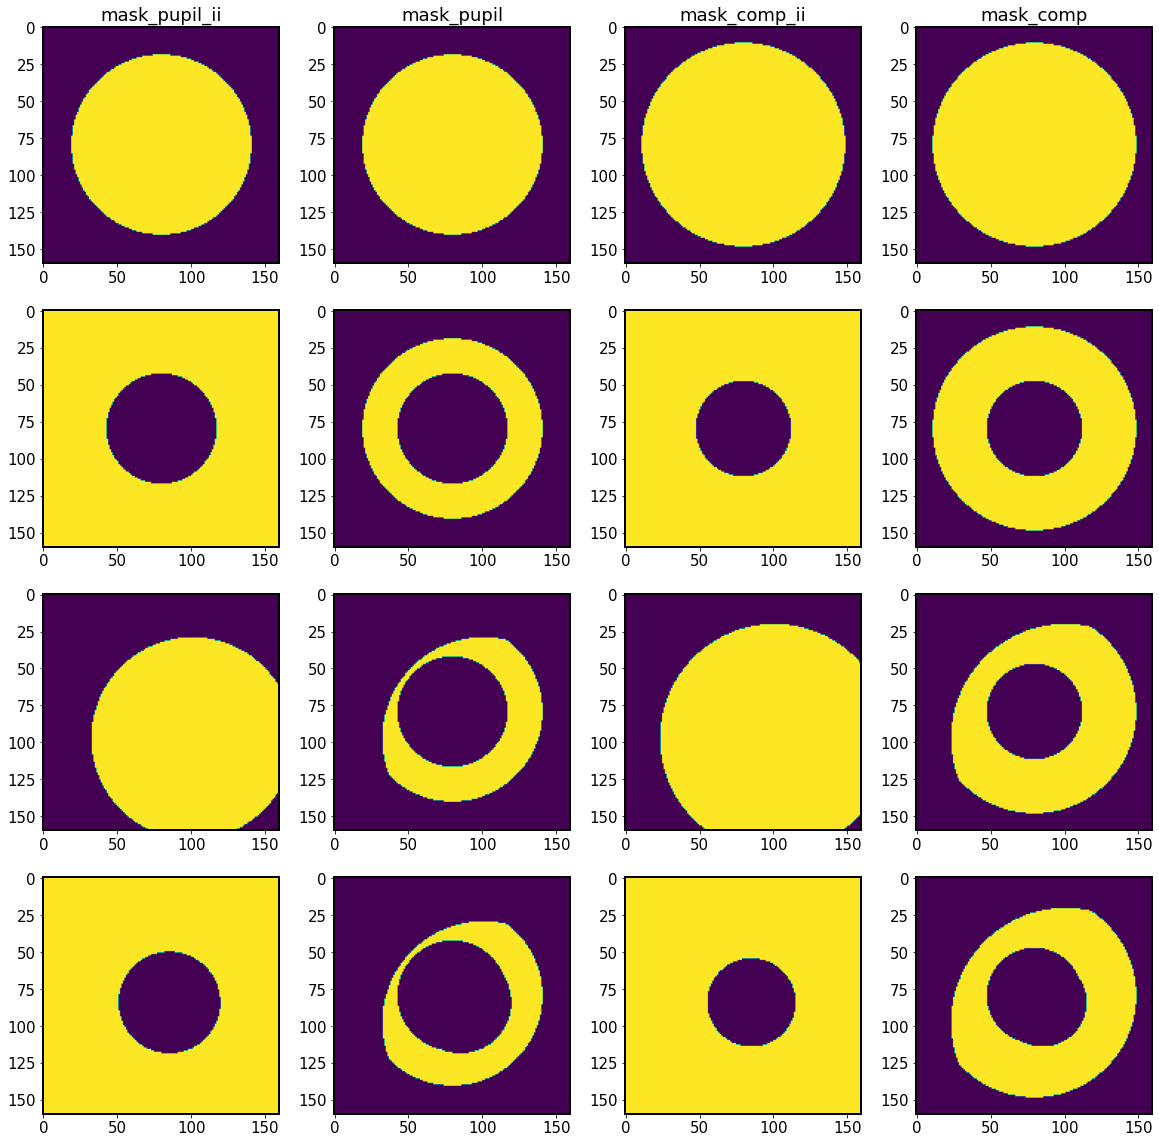

In [27]:
show_make_mask(imgExtra,inst,algo ,
               maskCaRaCbRb=[-0.45521073725716857, 
                             1.1229798828875915, 
                             -0.11778923546544409, 
                             0.5644657645345559] )

In [20]:
maskParam = inst.getMaskOffAxisCorr()
ruler = np.sqrt(2) * maskParam[:, 0]

In [21]:
ruler

array([1.51320851, 1.55386715, 1.59452579, 1.63518443, 1.67584307,
       1.71650171, 1.75716035, 1.79781899, 1.83847763])

In [16]:
maskCa

-0.29521073725716857

In [19]:
cay


0.19299900928159672

In [17]:
maskCb

-0.11778923546544409

In [ ]:
masklist = self.makeMaskList(inst, model)
for ii in range(masklist.shape[0]):

    # Distance to center on pupil
    r = np.sqrt(
        (xSensor - masklist[ii, 0]) ** 2 + (ySensor - masklist[ii, 1]) ** 2
    )

    # Find the indices that correspond to the mask element, set them to
    # the pass/ block boolean

    # Get the index inside the aperture
    idx = r <= masklist[ii, 2]

    # Get the higher and lower boundary beyond the pupil mask by
    # extension.
    # The extension level is dicided by boundaryT.
    # In fft, this is also the Neuman boundary where the derivative of
    # the wavefront is set to zero.
    if masklist[ii, 3] >= 1:
        aidx = np.nonzero(
            r <= masklist[ii, 2] * (1 + boundaryT * pixelSize / rMask)
        )
    else:
        aidx = np.nonzero(
            r <= masklist[ii, 2] * (1 - boundaryT * pixelSize / rMask)
        )

    # Initialize both mask elements to the opposite of the pass/ block
    # boolean
    mask_pupil_ii = (1 - int(masklist[ii, 3])) * np.ones(
        [dimOfDonut, dimOfDonut], dtype=int
    )
    mask_comp_ii = mask_pupil_ii.copy()

    mask_pupil_ii[idx] = int(masklist[ii, 3])
    mask_comp_ii[aidx] = int(masklist[ii, 3])

    # Multiplicatively add the current mask elements to the model
    # masks.
    # This is try to find the common mask region.

    # non-padded mask corresponding to aperture
    self.mask_pupil = self.mask_pupil * mask_pupil_ii

    # padded mask for use at the offset planes
    self.mask_comp = self.mask_comp * mask_comp_ii